# Data Processing and Analysis - Basis Technologies Interview Assignment

In [1]:
import pymysql
import pandas as pd
import matplotlib.pyplot as plt
plt.close("all")

In [2]:
conn = pymysql.connect(
host='localhost',
port=3305,
user='root',
password='123456',
database='interview',
charset='utf8')

## 1 Database Overview

### 1.1 Show data of dim_customers

In [3]:
df_customers=pd.read_sql("SELECT * FROM dim_customer",con=conn)
df_customers.head()

,customer_id,name,segment
0,32,3e24af1eb3b1cee9b4c980e31061da704367db00e22a91...,Segment B
1,37,04d88f5d26b4a9f38be30bc079f427f77affbf0920216a...,Segment A
2,123,8e75517c1103e852feefb34c3e185aeb536f5e80b014ef...,Segment B
3,444,acb475452906005b2bc4d95a4ab8bf1902c5b7d1586fc6...,Segment A
4,488,a3b97697baa6a8d9640d2d02e2a53016e54812f306c272...,Segment A


### 1.2 show data of fact_date_customer_campaign

In [4]:
df_fact=pd.read_sql("SELECT * FROM fact_date_customer_campaign",con=conn)
df_fact.head()

,date,customer_id,campaign_id,cost,datacost,revenue
0,2017-01-01,1300,53531,0.002750,0.0,0.001110
1,2017-01-01,3058,34922,0.016703,0.0,0.003349
2,2017-01-01,1239,37750,2.925945,0.0,0.617055
3,2017-01-01,4715,55032,0.010428,0.0,0.003072
4,2017-01-01,6121,67501,0.766920,0.0,0.217341


## 2. Data Preprocessing - Check abnormal nor NULL data in the database

### 2.1 Table fact_date_customer_campaign

In [5]:
# check whether there are any null values in the table

df=pd.read_sql("""SELECT * FROM fact_date_customer_campaign WHERE date IS NULL 
OR customer_id IS NULL OR cost IS NULL OR datacost IS NULL OR revenue IS NULL""",con=conn)
df.head()

,date,customer_id,campaign_id,cost,datacost,revenue


### 2.2 Table dim_customer

In [6]:
# check whethet there are duplicated values in the table.
# Because customer_id is the primary key, we can be definitely sure the customer_id be unique.
# However, still need to have a check in case nothing goes wrong when connecting with data base.

df=pd.read_sql("SELECT customer_id,COUNT(*) AS customer_num FROM dim_customer GROUP BY customer_id HAVING COUNT(*)>1",con=conn)
df.head()

,customer_id,customer_num


## 3. Solutions to Part 1

### 3.1 Questions

o How many customers are there in total?

o How many customers are there in segment A?

o How many customers are there in segment B?

o How much total gross revenue was there for the year (both segments)?

o How much total net revenue was there for the year (both segments)?



### 3.2 SQL statement for the questions
SELECT COUNT(*) AS total_customers FROM dim_customer;

SELECT COUNT(*) AS segment_a_customers FROM dim_customer WHERE segment='Segment A';

SELECT COUNT(*) AS segment_b_customers FROM dim_customer WHERE segment='Segment B';

SELECT segment, COUNT(*) AS customers FROM dim_customer GROUP BY segment;

SELECT SUM(cost + datacost + revenue) AS total_gross_revenue FROM fact_date_customer_campaign;

SELECT SUM(revenue) AS total_net_revenue FROM fact_date_customer_campaign;

### 3.3 Answers to Part 1

#### 3.3.1 How many customers are there in total?

In [7]:
# because customer_id is the primary key, thus don't need to use DISTINCT to avoid duplicate result
total_customers = pd.read_sql("SELECT COUNT(*) AS total_customers FROM dim_customer", con=conn)
total_customers


,total_customers
0,859


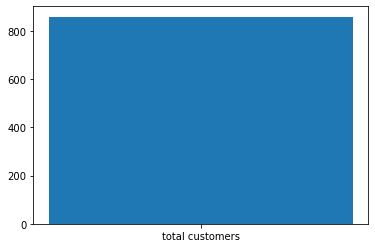

In [8]:
x=['total customers']

df=total_customers

y=df['total_customers']
plt.bar(x, y)
 
plt.show()

#### 3.3.2 How many customers are there in segment A?

In [9]:
segment_a=pd.read_sql("SELECT COUNT(*) AS segment_a_customers FROM dim_customer WHERE segment='Segment A'", con=conn)
segment_a

,segment_a_customers
0,832


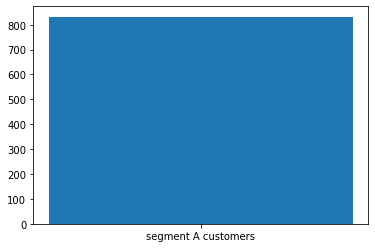

In [10]:
x=['segment A customers']

df=segment_a
y=df['segment_a_customers']
plt.bar(x, y)
 
plt.show()

#### 3.3.3 How many customers are there in segment B?

In [11]:
segment_b=pd.read_sql("SELECT COUNT(*) AS segment_b_customers FROM dim_customer WHERE segment='Segment B'", con=conn)
segment_b

,segment_b_customers
0,27


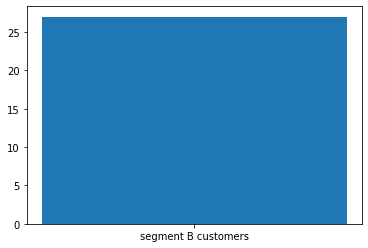

In [12]:
x=['segment B customers']

df=segment_b
y=df['segment_b_customers']
plt.bar(x, y)
 
plt.show()

In [13]:
segment_ab=pd.read_sql("SELECT segment, COUNT(*) AS customers FROM dim_customer GROUP BY segment", con=conn)
segment_ab

,segment,customers
0,Segment A,832
1,Segment B,27


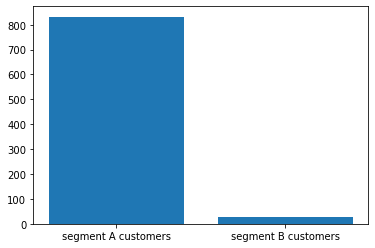

In [14]:
x=['segment A customers','segment B customers']

df=segment_ab
y=df['customers']
plt.bar(x, y)
 
plt.show()

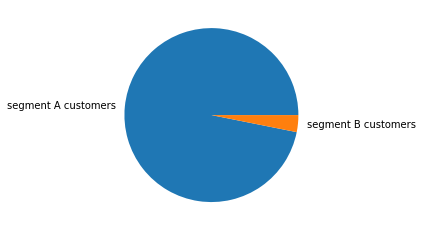

In [15]:
x=['segment A customers','segment B customers']

df=segment_ab
y=df['customers']

plt.pie(x=y, labels=x)

plt.show()

#### 3.3.4 How much total gross revenue was there for the year (both segments)?

In [16]:
total_gross_revenue=pd.read_sql("SELECT SUM(cost + datacost + revenue) AS total_gross_revenue FROM fact_date_customer_campaign", con=conn)
total_gross_revenue


,total_gross_revenue
0,1.546333e+07


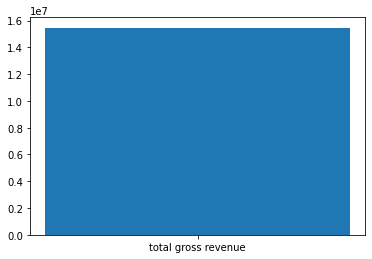

In [17]:
x=['total gross revenue']

df=total_gross_revenue
y=df['total_gross_revenue']
plt.bar(x, y)
 
plt.show()


#### 3.3.5 How much total net revenue was there for the year (both segments)?

In [18]:
total_net_revenue=pd.read_sql("SELECT SUM(revenue) AS total_net_revenue FROM fact_date_customer_campaign", con=conn)
total_net_revenue

,total_net_revenue
0,4.284116e+06


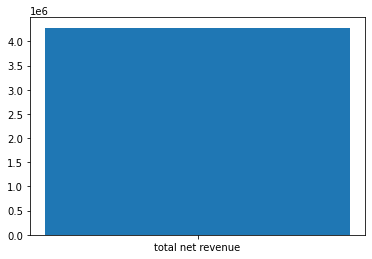

In [19]:
x=['total net revenue']

df=total_net_revenue
y=df['total_net_revenue']
plt.bar(x, y)
 
plt.show()

#### 3.3.6 Other calculation for futher analysis

##### (1)  Total Margin percentage ( = net/gross)


In [20]:
margin_percentage=pd.read_sql("SELECT CONCAT(SUM(revenue)*100/SUM(cost + datacost + revenue),'%') AS margin_percentage FROM fact_date_customer_campaign",con=conn)
margin_percentage

,margin_percentage
0,27.705013719433075134167966982402%


## 4. Solutions to Part 2 

### 4.1 Day-over-Day (D/D) Gross growth 

SELECT distinct t.date,
(
SELECT MAX(date)
FROM
(SELECT DISTINCT date FROM fact_date_customer_campaign) tt
WHERE t.Date>tt.Date ) AS last_date
FROM
(SELECT DISTINCT date FROM fact_date_customer_campaign) t;

In [21]:
## check day-over-day continue.
dd=pd.read_sql("SELECT distinct t.date,( SELECT MAX(date) FROM (SELECT DISTINCT date FROM fact_date_customer_campaign) tt WHERE t.Date>tt.Date ) AS last_date FROM (SELECT DISTINCT date FROM fact_date_customer_campaign) t", con=conn)
dd

,date,last_date
0,2017-01-01,None
1,2017-01-02,2017-01-01
2,2017-01-03,2017-01-02
3,2017-01-04,2017-01-03
4,2017-01-05,2017-01-04
...,...,...
360,2017-12-27,2017-12-26
361,2017-12-28,2017-12-27
362,2017-12-29,2017-12-28
363,2017-12-30,2017-12-29


### 4.2 Generate the final report shown the statistics for Segment A Only

In [22]:
dd=pd.read_sql(""" SELECT t1.Date, 
CONCAT('$',FORMAT(t1.Gross,2)) AS Gross, 
CONCAT('$',FORMAT(t1.Net,2)) as Net, 
t1.Margin,
IFNULL(CONCAT((t1.Gross- t3.Gross)*100/t3.Gross,'%'),'0%') AS "D/D Gross"
FROM
(
SELECT date AS Date, SUM(cost + datacost + revenue) AS Gross,
SUM(revenue) AS Net,
CONCAT(SUM(revenue)*100/SUM(cost + datacost + revenue),'%') AS Margin
FROM fact_date_customer_campaign 
JOIN dim_customer 
ON fact_date_customer_campaign.customer_id=dim_customer.customer_id
WHERE dim_customer.segment='Segment A'
GROUP BY date
) t1 LEFT JOIN 
(
SELECT distinct t.date,
(
SELECT MAX(date)
FROM
(SELECT DISTINCT date FROM fact_date_customer_campaign) tt
WHERE t.Date>tt.Date ) AS last_date
FROM
(SELECT DISTINCT date FROM fact_date_customer_campaign) t
) t2 ON t1.Date=t2.date
LEFT JOIN
(
SELECT date AS Date, SUM(cost + datacost + revenue) AS Gross,
SUM(revenue) AS Net,
CONCAT(SUM(revenue)*100/SUM(cost + datacost + revenue),'%') AS Margin
FROM fact_date_customer_campaign
JOIN dim_customer 
ON fact_date_customer_campaign.customer_id=dim_customer.customer_id
WHERE dim_customer.segment='Segment A'
GROUP BY date
) t3 ON t3.Date=t2.last_date """, con=conn)

dd

,Date,Gross,Net,Margin,D/D Gross
0,2017-01-01,"$19,993.89","$5,246.83",26.242160523090219813146272491027%,0%
1,2017-01-02,"$22,456.87","$5,985.16",26.651816440061076690677426348069%,12.318671510142766153527845180242%
2,2017-01-03,"$23,462.06","$6,304.96",26.873016591276207907909013474067%,4.476094333916550978825064391504%
3,2017-01-04,"$24,206.65","$6,470.14",26.728762991695361060033841180968%,3.173563036746938607345253287500%
4,2017-01-05,"$24,429.29","$6,607.21",27.046248091943340663176980508609%,0.919745491650233301673734306873%
...,...,...,...,...,...
360,2017-12-27,"$59,071.20","$15,910.64",26.934688530058786961314697442465%,5.425181878269746276552428095548%
361,2017-12-28,"$65,965.25","$17,451.87",26.456155589190101407370100057496%,11.670740880215682880934037224785%
362,2017-12-29,"$58,030.67","$15,706.02",27.065030226992309738175386697648%,-12.028430078424703909780452384109%
363,2017-12-30,"$49,732.01","$13,027.27",26.194929542701193913264739204981%,-14.300462312846384475904122399215%


<!-- SELECT t1.Date, 
CONCAT('$',FORMAT(t1.Gross,2)) AS Gross, 
CONCAT('$',FORMAT(t1.Net,2)) as Net,
t1.Margin,
IFNULL(CONCAT(ROUND((t1.Gross- t3.Gross)*100/t3.Gross,0),'%'),'-') AS "D/D Gross"
FROM
(
SELECT date AS Date, SUM(cost + datacost + revenue) AS Gross,
SUM(revenue) AS Net,
CONCAT(ROUND(SUM(revenue)*100/SUM(cost + datacost + revenue),0),'%') AS Margin
FROM fact_date_customer_campaign
GROUP BY date
) t1 LEFT JOIN 
(
SELECT distinct t.date,
(
SELECT MAX(date)
FROM
(SELECT DISTINCT date FROM fact_date_customer_campaign) tt
WHERE t.Date>tt.Date ) AS last_date
FROM
(SELECT DISTINCT date FROM fact_date_customer_campaign) t
) t2 ON t1.Date=t2.date
LEFT JOIN
(
SELECT date AS Date, SUM(cost + datacost + revenue) AS Gross,
SUM(revenue) AS Net,
CONCAT(ROUND(SUM(revenue)*100/SUM(cost + datacost + revenue),0),'%') AS Margin
FROM fact_date_customer_campaign
GROUP BY date
) t3 ON t3.Date=t2.last_date; -->


In [23]:
dd=pd.read_sql(""" SELECT t1.Date, 
CONCAT('$',FORMAT(t1.Gross,2)) AS Gross, 
CONCAT('$',FORMAT(t1.Net,2)) as Net, 
t1.Margin,
IFNULL(CONCAT((t1.Gross- t3.Gross)*100/t3.Gross,'%'),'0%') AS "D/D Gross"
FROM
(
SELECT date AS Date, SUM(cost + datacost + revenue) AS Gross,
SUM(revenue) AS Net,
CONCAT(SUM(revenue)*100/SUM(cost + datacost + revenue),'%') AS Margin
FROM fact_date_customer_campaign
JOIN dim_customer 
ON fact_date_customer_campaign.customer_id=dim_customer.customer_id
WHERE dim_customer.segment='Segment A'
GROUP BY date
) t1 LEFT JOIN 
(
SELECT distinct t.date,
(
SELECT MAX(date)
FROM
(SELECT DISTINCT date FROM fact_date_customer_campaign) tt
WHERE t.Date>tt.Date ) AS last_date
FROM
(SELECT DISTINCT date FROM fact_date_customer_campaign) t
) t2 ON t1.Date=t2.date
LEFT JOIN
(
SELECT date AS Date, SUM(cost + datacost + revenue) AS Gross,
SUM(revenue) AS Net,
CONCAT(SUM(revenue)*100/SUM(cost + datacost + revenue),'%') AS Margin
FROM fact_date_customer_campaign
JOIN dim_customer 
ON fact_date_customer_campaign.customer_id=dim_customer.customer_id
WHERE dim_customer.segment='Segment A'
GROUP BY date
) t3 ON t3.Date=t2.last_date """, con=conn)


def format1(column):
    return int(round(float(column[:-1]),0))

def format2(column):
    return str(column)+'%'


dd['Margin']=dd['Margin'].apply(lambda x: format1(x))
dd['D/D Gross']=dd['D/D Gross'].apply(lambda x :format1(x))
    
dd['Margin']=dd['Margin'].apply(lambda x: format2(x))
dd['D/D Gross']=dd['D/D Gross'].apply(lambda x :format2(x))

dd

,Date,Gross,Net,Margin,D/D Gross
0,2017-01-01,"$19,993.89","$5,246.83",26%,0%
1,2017-01-02,"$22,456.87","$5,985.16",27%,12%
2,2017-01-03,"$23,462.06","$6,304.96",27%,4%
3,2017-01-04,"$24,206.65","$6,470.14",27%,3%
4,2017-01-05,"$24,429.29","$6,607.21",27%,1%
...,...,...,...,...,...
360,2017-12-27,"$59,071.20","$15,910.64",27%,5%
361,2017-12-28,"$65,965.25","$17,451.87",26%,12%
362,2017-12-29,"$58,030.67","$15,706.02",27%,-12%
363,2017-12-30,"$49,732.01","$13,027.27",26%,-14%


### 4.3 Store the results in to Excel named "report_output.xlsx"

In [24]:
## save the above result into excel.
writer = pd.ExcelWriter('./report_output.xlsx')
df=dd
df.to_excel(writer, sheet_name='Sheet1', na_rep='', float_format=None, columns=None, header=True, index=False, index_label=None, startrow=0, startcol=0, engine=None, merge_cells=True, encoding=None, inf_rep='inf', verbose=True, freeze_panes=None)
writer.save()

### 4.4 Data visulization for the KPIs

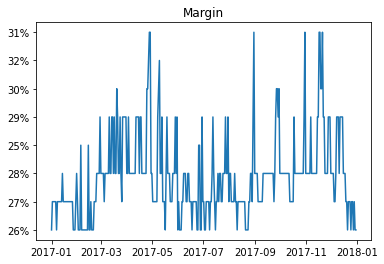

In [25]:
dd=df
x=dd["Date"]
y=dd["Margin"]
plt.title("Margin")
plt.plot(x, y)

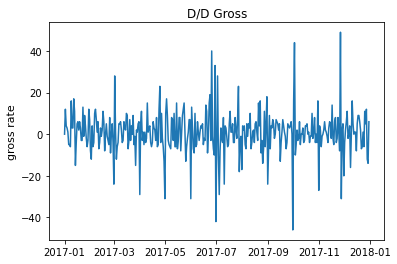

In [26]:
dd=df
x=dd["Date"]
y=dd["D/D Gross"]
y_y=[]
for yy in y:
    if yy!='-':
        y_y.append(int(yy[:-1]))
    else:
        y_y.append(0)
plt.ylabel("gross rate", fontsize=11)

plt.title("D/D Gross")
plt.plot(x, y_y)

## 5. Solutions to Part 3 and further thinking about this assignment

Check the answers in "summary.docx" file 